In [ ]:
from koala.pointsets import uniform
from koala import graph_utils as gu
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.flux_finder import fluxes_from_ujk, ujk_from_fluxes
from koala.lattice import Lattice
from scipy import linalg as la
from pfapack.pfaffian import pfaffian

from koala import example_graphs as eg
from dimer_models.koala_plantri import plantri_to_koala, plantri_generator, read_plantri
from dimer_models.lattice_generation import (
    bipartite_squarefull,
    reduce_bipartite,
)

from dimer_models.kasteleyn import kasteleyn_matrix, find_kasteleyn_number

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from copy import copy

In [ ]:
from dimer_models.lattice_generation import (
    find_expandable_plaquettes,
    expand_plaquette_square_boundary,
)


def reduce_bipartite(lattice: Lattice, n_steps=None):

    if n_steps == None:
        r = lattice.n_plaquettes
    else:
        r = n_steps
    reduced_lattice = copy(lattice)
    for n in range(r):

        options = find_expandable_plaquettes(reduced_lattice)
        if len(options) == 0:
            break

        side_lengths = [p.n_sides for p in reduced_lattice.plaquettes[options]]
        n_sides = np.array([p.n_sides for p in reduced_lattice.plaquettes[options]])

        number_of_good_neighbours = np.array(
            [
                np.sum(np.isin(p.adjacent_plaquettes, options))
                for p in reduced_lattice.plaquettes[options]
            ]
        )

        # print(number_of_good_neighbours, np.argmin(number_of_good_neighbours))
        # first_choice = np.random.choice(options)

        first_choice = options[np.argmin(number_of_good_neighbours)]
        x = reduced_lattice.plaquettes[first_choice].adjacent_plaquettes
        reduced_lattice = expand_plaquette_square_boundary(
            reduced_lattice, first_choice
        )

    return reduced_lattice

In [25]:
ns = 400
lattice = gu.com_relaxation(generate_lattice(uniform(ns)))
lat_sq = gu.com_relaxation(bipartite_squarefull(ns))
lat_red = gu.com_relaxation(reduce_bipartite(lat_sq))

lattices = [lattice, lat_sq, lat_red]

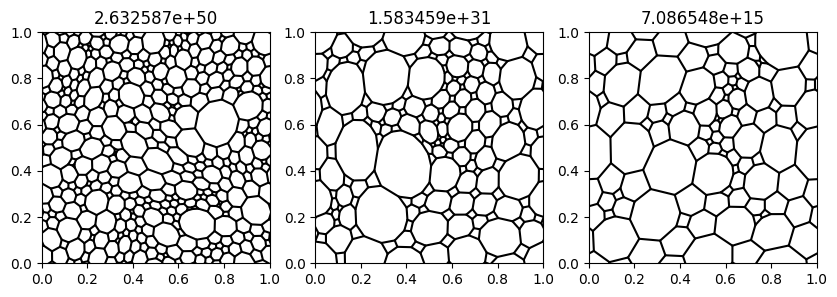

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

for j, lat in enumerate(lattices):
    n = find_kasteleyn_number(lat)
    ax[j].set_title(f"{n:4e}")
    pl.plot_edges(lat, ax=ax[j])

In [ ]:
from pfapack.pfaffian import pfaffian
import pfapack


def find_kasteleyn_number(lattice: Lattice) -> int:
    """Given a matrix, find the total number of dimerisations
    using the FKT algorithm

    Args:
        lattice (Lattice): The lattice to work on

    Raises:
        Exception: Kasteleyn only works in periodic and open boundaries

    Returns:
        int: The number of valid dimerisations.
    """

    ujk = ujk_from_fluxes(lattice, np.array([-1] * lattice.n_plaquettes))
    if np.all(lattice.boundary_conditions == False):
        assert np.all(fluxes_from_ujk(lattice, ujk) == -1)
        K = kasteleyn_matrix(lattice, ujk)
        return abs(round(pfaffian(K)))
    elif np.all(lattice.boundary_conditions == True):
        pass
    else:
        raise Exception("Kasteleyn only works in periodic and open boundaries")

    x_boundary_edges = np.where(lattice.edges.crossing[:, 0] != 0)
    y_boundary_edges = np.where(lattice.edges.crossing[:, 1] != 0)
    all_ujks = np.array([[ujk] * 2] * 2)
    all_ujks[1, :, x_boundary_edges] *= -1
    all_ujks[:, 1, y_boundary_edges] *= -1
    ujk_list = all_ujks.reshape([-1, all_ujks.shape[-1]])

    n_vals = []
    for u in ujk_list:
        assert np.all(fluxes_from_ujk(lattice, u) == -1)
        K = kasteleyn_matrix(lattice, u)
        # x = pfapack.pfaffian.skew_tridiagonalize(K, calc_q=False)

        # print(np.prod(np.diag(x, 1)))
        n_vals.append(round(pfaffian(K)))
        # print(n_vals[-1])

    if np.all(lattice.boundary_conditions):
        m = np.ones([4, 4]) - 2 * np.eye(4)
        options = np.abs(np.sum(m * np.array(n_vals), axis=1)) // 2

    return int(np.max(options))


find_kasteleyn_number(lat_red)

-4244920826347612
-68274108671958
-5894073708964223
-4102375070088578


7086547748364227